# Linearized buckling analysis of a beam under its own weight

In [1]:
from dolfin import *
from mshr import *
import ufl 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from slepc4py import SLEPc
from slepc_eigensolver import EigenSolver

%matplotlib inline
plt.style.use('seaborn-notebook')

## Problem formulation

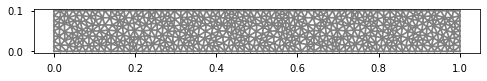

In [29]:

# Create mesh and define boundaries fof BCs
Lx, Ly = 1., .1
geom = Rectangle(Point(0,0),Point(Lx,Ly))
mesh = generate_mesh(geom,40)
n = mesh.geometry().dim() # number of space dimensions
plot(mesh)
# Mark boundary subdomains
left = CompiledSubDomain("near(x[0],0) && on_boundary")
right = CompiledSubDomain("near(x[0],Lx) && on_boundary", Lx=Lx)
bottom = CompiledSubDomain("near(x[1],0) && on_boundary")
# Mark facets for Neuman BCs
boundary_markers = MeshFunction("size_t", mesh,1,0)
left.mark(boundary_markers, 1)
right.mark(boundary_markers, 2)
ds = ds(domain=mesh,subdomain_data=boundary_markers)


In [30]:
# Elasticity parameters
E, nu = 70.e6, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))
lmbda = 2*lmbda*mu/(lmbda + 2*mu) # This is to put plane-stress moduli

In [31]:
V_element = VectorElement('CG',triangle, 2) 
scalar_element = FiniteElement('CG',triangle,2) 
V = FunctionSpace(mesh, V_element)
V_scalar = FunctionSpace(mesh, scalar_element)

# Define functions
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function

# Kinematics
Id = Identity(n)    # Identity tensor

# Stress (linear elasticity)
def sigma(eps):
    return lmbda*ufl.tr(eps)*Id+2*mu*eps

# External loads
rho_g =  E * Ly**2 / 12 / Lx**3
b0 = dolfin.Expression(("-t*rho_g*cos(alpha)", "t*rho_g*sin(alpha)"),
                           t=0, alpha=0, rho_g=rho_g, degree=0)  


## Linearized buckling analysis 

For the linearized buckling analysis we procede as follows:

 1. Solve the linear elasticity problem to get the stress state $\sigma_0$ for a given loading

 2. Solve the linearized buckling problem around this prestressed reference configuration

### 1. Linearization around prestresed undeformed approximated solution to get the initial stress state

We solve here the basic linear elasticity problem to get $\sigma_0$

Text(0.5, 1.0, 'Axial stress $\\sigma_{xx}$ for the linear elastic solution with unit load')

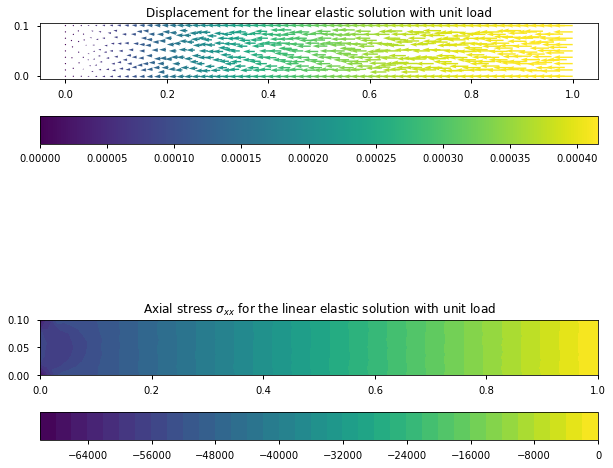

In [32]:


u_0  = Function(V)                 # Displacement from previous iteration
a_k = inner(sigma(sym(grad(du))),sym(grad(v)))*dx
L = inner(b0,v)*dx 
bcs = [dolfin.DirichletBC(V, (0., 0.), left)]
b0.t = 1
A, b = assemble_system(a_k,L,bcs)
solve(A,u_0.vector(),b)

figure = plt.figure(figsize = (10, 10))
plt.subplot(2,1,1)
plt.colorbar(plot(u_0),orientation="horizontal")
plt.title("Displacement for the linear elastic solution with unit load")


plt.subplot(2,1,2)
V_sigma = TensorFunctionSpace(mesh,'DG',0)
sigma_0 = dolfin.project(sigma(sym(grad(u_0))),V_sigma)
plt.colorbar(plot(sigma_0[0,0]),orientation="horizontal")
plt.title(r"Axial stress $\sigma_{xx}$ for the linear elastic solution with unit load")


### 2. Eigenvalue problem around the prestressed configuration

Let us now solve the eigenvalue problem around the prestressed configuration

Find the load multiplying factors $\lambda^{(i)}$ such that there exist non vanishing solutions $u^{(i)}\in \mathcal{C}_0$ to the linearized problem with prestress $\sigma_0$:

$$
\int_\Omega \sigma(\varepsilon(u^{(i)}))\cdot\varepsilon(v)\mathrm{d}x - \lambda^{(i)} \int_\Omega \sigma_0 \cdot(\nabla u^{(i)T}\,\nabla v)\,\mathrm{d}x,\forall v\in\mathcal{C}_0 
$$
where in the repeted indeces notation
$\sigma_0\cdot(\nabla u^{(i)T}\nabla v)=(\sigma_0)_{hk}\,u^{(i)}_{m,k}v_{m,k}$ 


{ ({ A | A_{i_{143}, i_{144}} = -1 * f_936[i_{143}, i_{144}] }) : ({ A | A_{i_{145}, i_{146}} = sum_{i_{147}} ((grad(v_1))^T)[i_{145}, i_{147}] * (grad(v_0))[i_{147}, i_{146}]  }) } * dx(<Mesh #893>[everywhere], {})
---- setting additional slepc options -----
     eps_max_it : 100
Solution method: krylovschur, stopping condition: tol=1e-08, maxit=100
Number of converged/requested eigenvalues with 3 iterations  : 7/7
saved eigenvectors in  output/buckling-modes.pvd


array([  7.74016361+0.j,  50.54520579+0.j, 115.32076245+0.j,
       183.98463565+0.j, 245.74260449+0.j, 296.42945497+0.j,
       335.58973915+0.j])

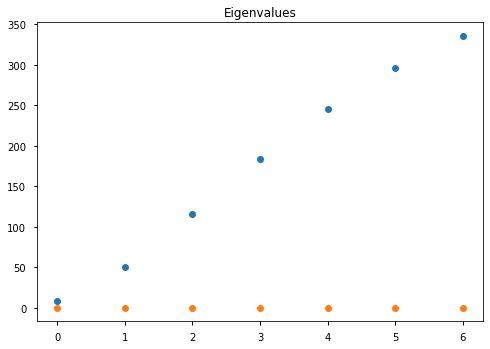

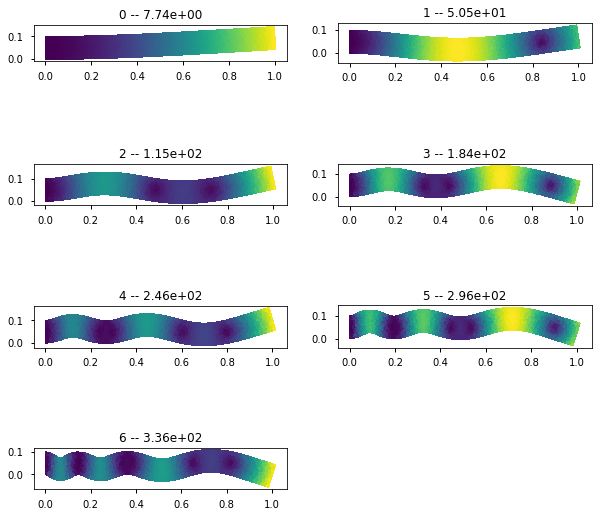

In [33]:

a_k = inner(sigma(sym(grad(du))),sym(grad(v)))*dx
a_g = inner(-sigma_0,grad(du).T*grad(v))*dx

# K = assemble(a_k)
# G = assemble(a_g)

# solving the eigenproblem
u_mode = Function(V) 
eig_solver = EigenSolver(a_k, u_mode, a_m=a_g, bcs=bcs)
neig = 7
ncv, it = eig_solver.solve(neig)
eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(ncv)
eig_solver.save_eigenvectors(ncv,file_name="output/buckling-modes.pvd")

# plots
plt.figure()
plt.plot(eigenvalues.real,'o')
plt.plot(eigenvalues.imag,'o')
plt.title("Eigenvalues")

figure = plt.figure(figsize = (10, 10))
for i in range(ncv):
    plt.subplot(int(ncv/2+1),2,i+1)
    dolfin.plot(eigenvectors_real[i],mode='displacement')
    plt.title("{:d} -- {:2.2e}".format(i,eigenvalues[i].real))
    
eigenvalues
